In [4]:
from os import listdir
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('classic')

from Libraries.features import CHurst, CEmbDim
from Libraries.Util import Norm01
from Libraries.Autoregr import VARExplore
from Libraries.Localapp import LAprExplore
from Libraries.Spectrum import MSSAExplore
from Libraries.ChooChoo import ChooChooExplore

import warnings
warnings.filterwarnings('ignore')

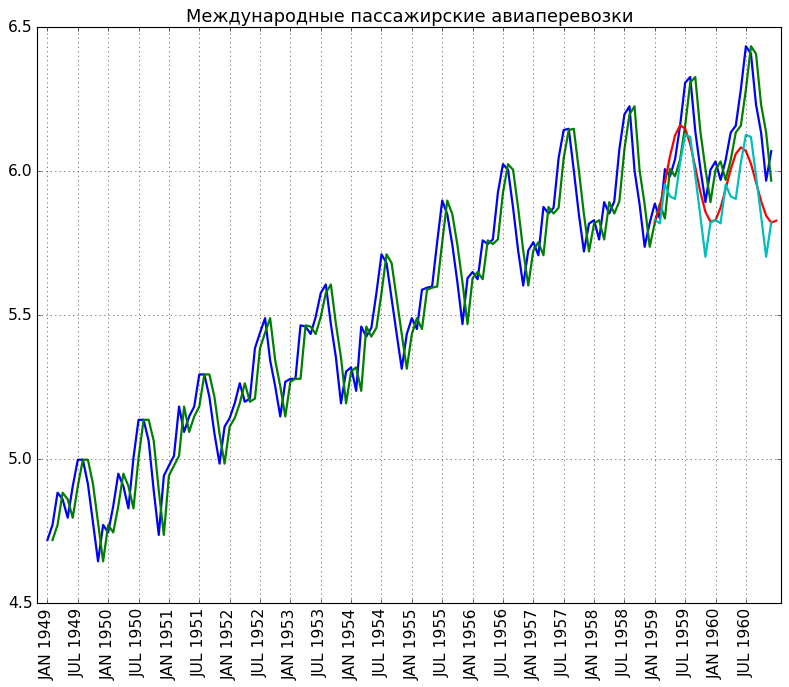

In [5]:
'''Регрессия и сглаживание'''
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
data=pd.read_csv('series_g.csv', sep=';')
x=np.log(data.series_g)
#x=data.series_g
model1 = ARIMA(x[:-24], order=(3, 0, 2))
results = model1.fit()

y=results.predict(len(data)-24, len(data))#+x.values[-24]

train, test = x[:120], x[120:]
model2 = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
z = model2.predict(start=test.index[0], end=test.index[-1])

fig=plt.figure(figsize=(12,9), facecolor='w')
xt=np.arange(0,len(data),6)
xtl=data.date.values[xt]
plt.plot(x, lw=2, label='initial series')
plt.plot(x.shift(1), lw=2, label='y(t+1)=y(t)')
plt.plot(y, lw=2, label='ARIMA(3,0,2)')
plt.plot(z, lw=2, label='Exponential smoothing')
plt.title('Международные пассажирские авиаперевозки', size=16)
#plt.ylabel('log(N)', size=16)
plt.xticks(xt, xtl, rotation=90, size=14)
plt.yticks(size=14)
plt.grid()
plt.xlim(-2, len(data)+1)
#plt.legend(fontsize=14, loc='best')
plt.show()

Constructing trajectory matrix
Trajectory matrix shape: (12, 133)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


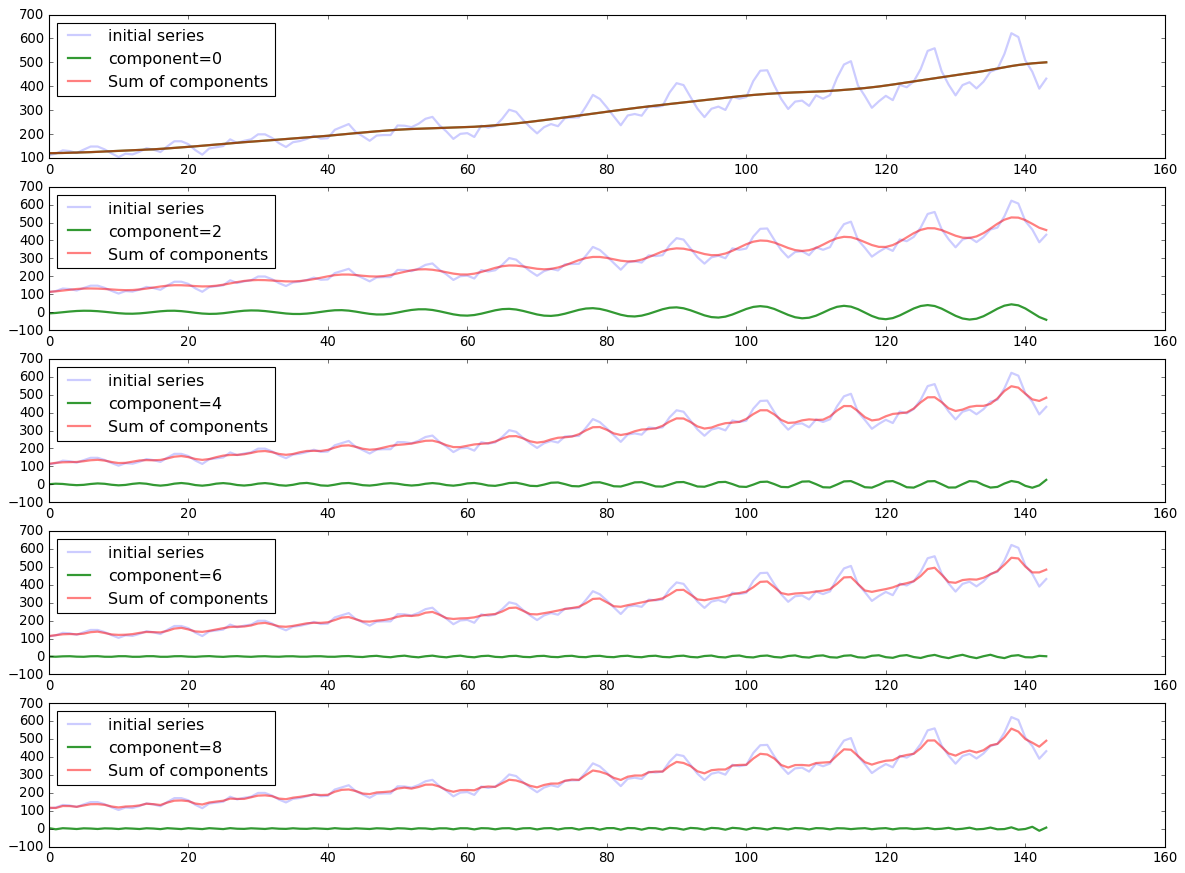

In [7]:
'''SSA'''
from pymssa import MSSA
mssa = MSSA(n_components=9,
            window_size=12,
            verbose=True)
x=data.series_g
mssa.fit(x)
z=np.zeros(len(x))
fig=plt.figure(figsize=(18, 13), facecolor='w')
for comp in range(9):
    if comp%2:
        continue
    ax = plt.subplot(5,1,comp//2+1)
    ax.plot(x.index, x.values, lw=2, alpha=0.2,  label='initial series')
    y=mssa.components_[0, :, comp]
    z=z+y
    ax.plot(x.index, y, lw=2, alpha=0.8, label='component={}'.format(comp))
    ax.plot(x.index, z, lw=2, alpha=0.5, label='Sum of components')
    ax.legend(loc='best')
plt.show()

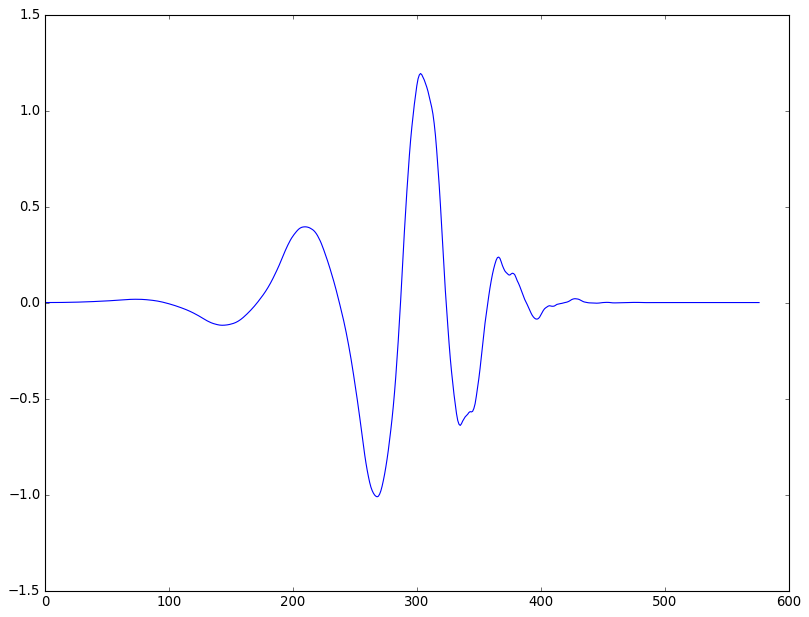

In [9]:
'''Вейвлеты'''
import pywt
w = pywt.Wavelet('db5')
fig=plt.figure(figsize=(12, 9), facecolor='w')
plt.plot(w.wavefun(6)[1])

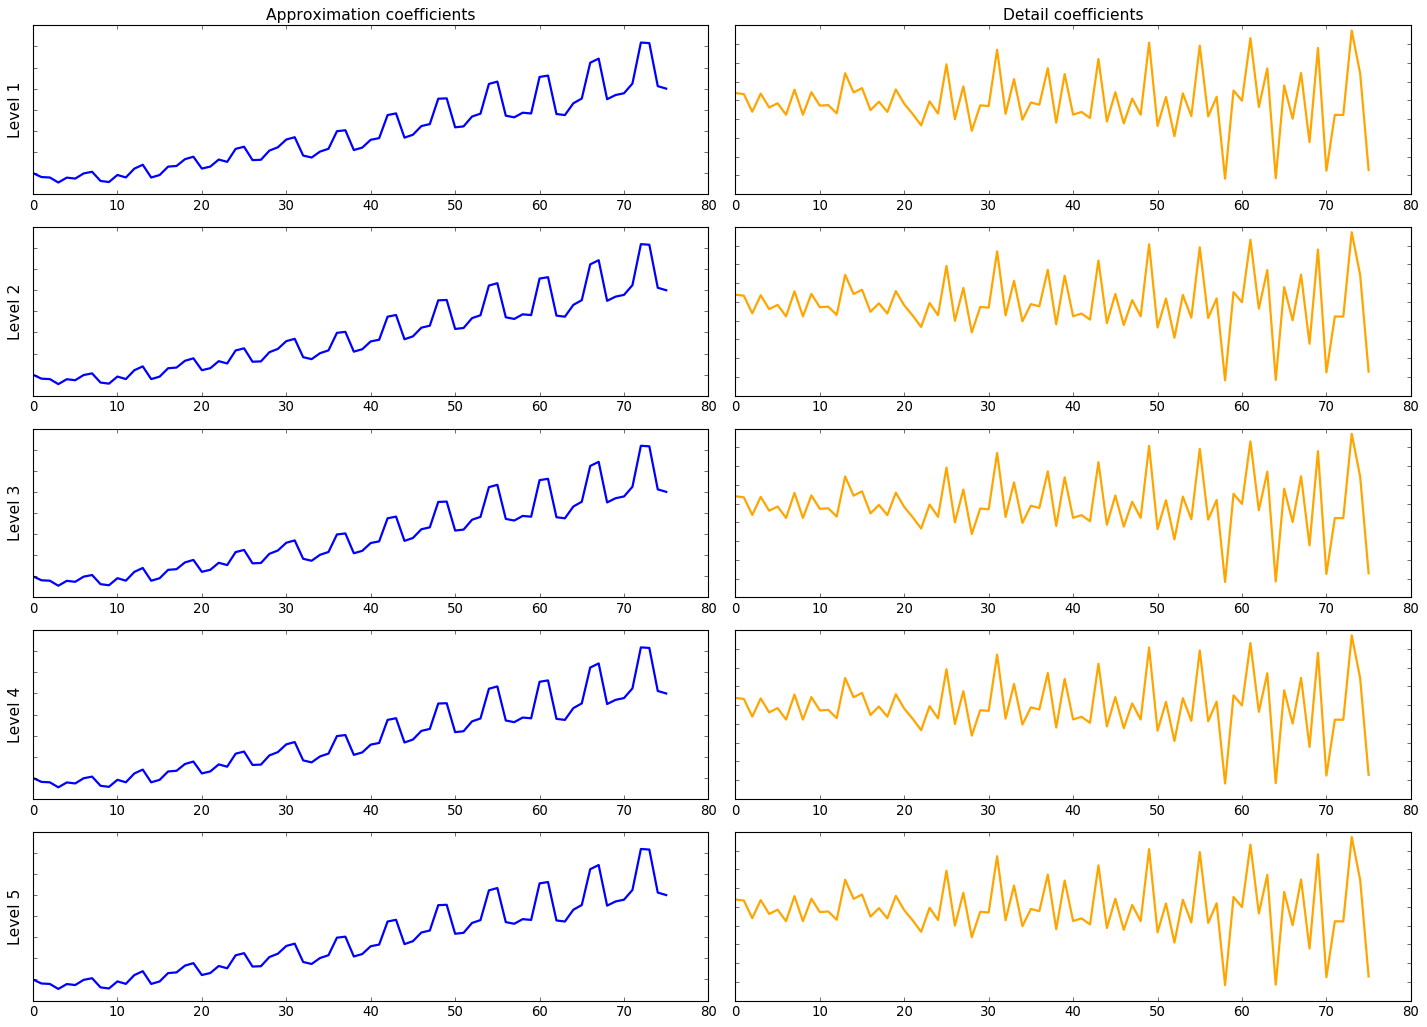

In [11]:
waveletname = 'db5'
n=5
fig, axarr = plt.subplots(nrows=n, ncols=2, figsize=(18,13), facecolor='w')
for ii in range(n):
    (y, coeff_d) = pywt.dwt(x, waveletname)
    axarr[ii, 0].plot(y, lw=2, c='b')
    axarr[ii, 1].plot(coeff_d,lw=2, c='orange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

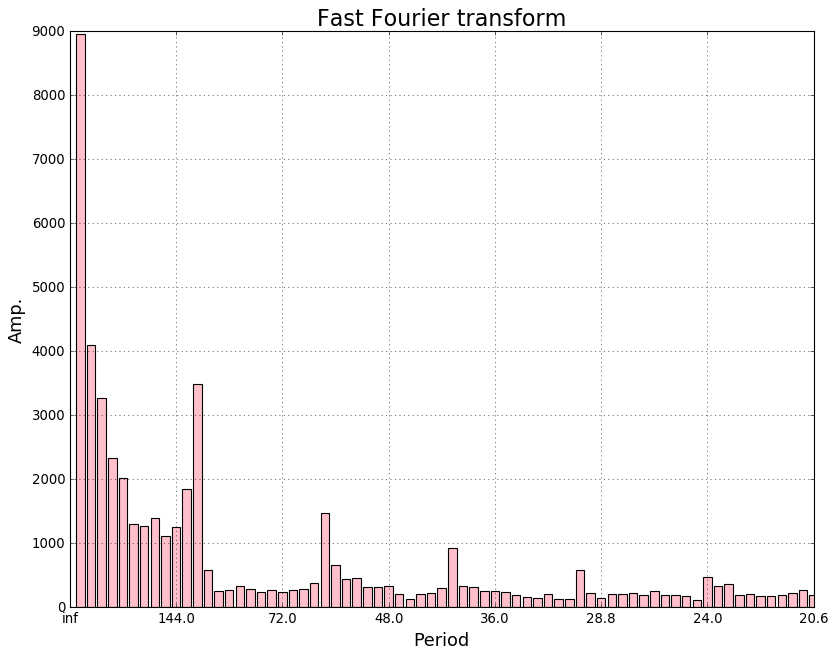

In [12]:
'''Фурье'''
F=np.fft.rfft(x-np.mean(x), n=None, axis=-1) # прямое быстрое преобразование Фурье в частотную область
A=[((F[i].real)**2+(F[i].imag)**2)**0.5 for i in np.arange(0,len(F))]#модуль амплитуды
a=[A.index(A[i])  for i in range(len(A))]

plt.figure(figsize=(12, 9), facecolor='w')
plt.title("Fast Fourier transform", size=20)
plt.xlim(0,31)
plt.bar(np.arange(0,len(F),1),A, color='pink')
plt.xticks(np.arange(0,len(F),10),np.round((len(data))/(np.array(a)),1), size=12)
plt.xlabel("Period", size=16)
plt.ylabel("Amp.", size=16)
plt.grid(True)

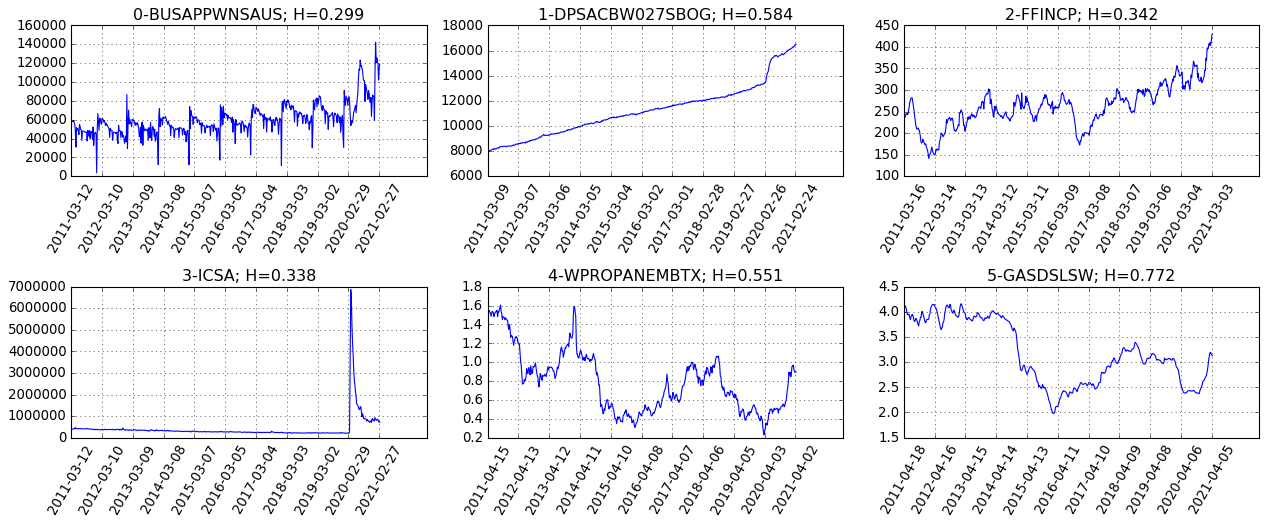

In [13]:
datadir='Weekly/'
datafiles=listdir(datadir)
fig=plt.figure(figsize=(16,9), facecolor='w')
n=len(datafiles)
collection=pd.DataFrame()

for j,i in enumerate(np.array(datafiles)[[4, 11, 14, 17, 25, 30]]):
    data=pd.read_csv(datadir+i, sep=',')
    xt=[data.DATE[i] for i in range(0, len(data), 52 )]
    data[data.columns[1]]=pd.to_numeric(data[data.columns[1]], errors='coerce', downcast='float')
    data.fillna(method='ffill',inplace=True)
    name=data.columns[1]
    y=data[name].values[:]
    h=CHurst(y)
    plt.subplot(3,3,j+1)
    plt.title(str(j)+'-'+name+'; H=%.3f'%h)
    plt.plot(y)
    plt.xticks(np.arange(0, len(data), 52 ), xt, rotation=60)
    plt.grid()
plt.tight_layout()
plt.show()

13

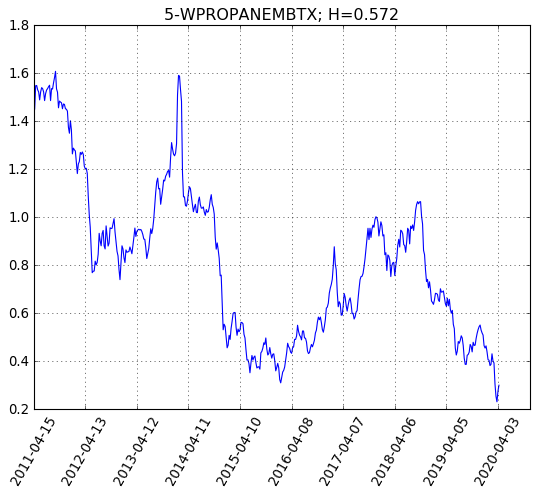

In [14]:
data=pd.read_csv(datadir+datafiles[25], sep=',')[:-52]
xt=[data.DATE.values[i] for i in range(0, len(data), 52 )]
data[data.columns[1]]=pd.to_numeric(data[data.columns[1]], errors='coerce', downcast='float')
data.fillna(method='ffill',inplace=True)
name=data.columns[1]
y=data[name].values[:]
h=CHurst(y)

plt.figure(facecolor='w')
plt.title(str(j)+'-'+name+'; H=%.3f'%h)
plt.plot(y)
plt.xticks(np.arange(0, len(data), 52 ), xt, rotation=60)
plt.grid()
CEmbDim(y)

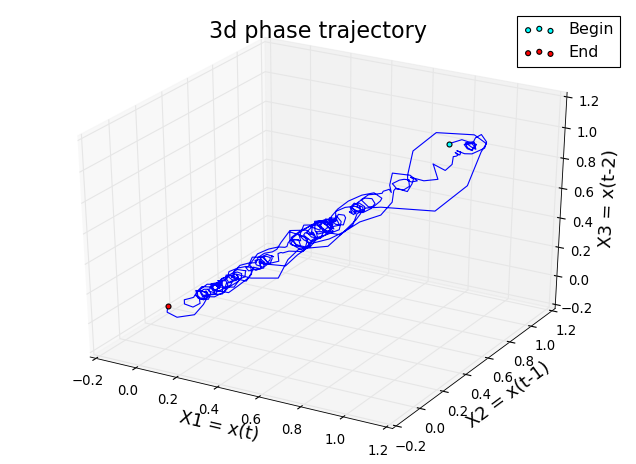

In [15]:
y1=y[:]
x1=Norm01(y1[:-2])[0]
x2=Norm01(y1[1:-1])[0]
x3=Norm01(y1[2:])[0]
fig = plt.figure(figsize=(10, 7), facecolor='w')
ax = fig.gca(projection='3d')
ax.plot(x1, x2, x3, lw=1)
ax.scatter(x1[0], x2[0], x3[0], c='cyan', label='Begin')
ax.scatter(x1[-1], x2[-1], x3[-1], c='red', label='End')
ax.set_xlabel("X1 = x(t)", size=16)
ax.set_ylabel("X2 = x(t-1)", size=16)
ax.set_zlabel("X3 = x(t-2)", size=16)
ax.set_title('3d phase trajectory', size=20)
plt.legend()
plt.show()

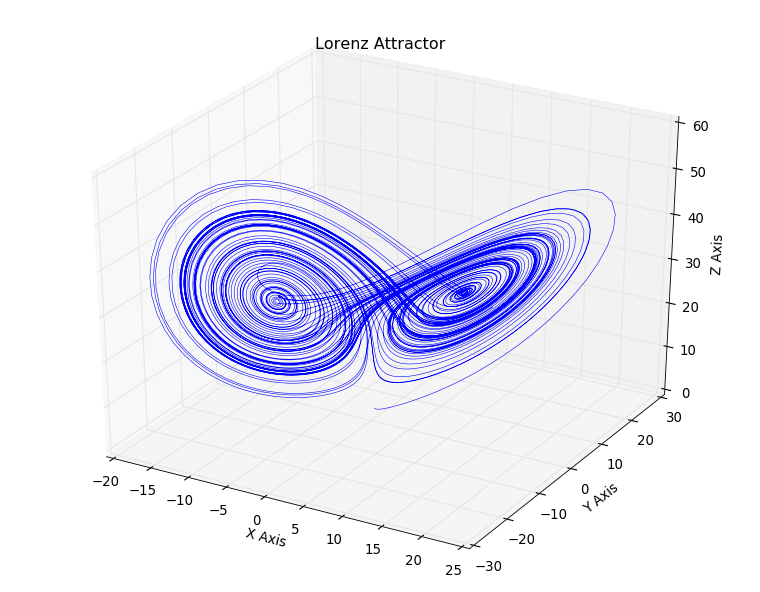

<Figure size 640x480 with 0 Axes>

In [16]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot
dt = 0.01
num_steps = 10000
# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)
# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)
# Plot
fig = plt.figure(figsize=(12, 9), facecolor='w')
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()
plt.savefig('Lorenz Attractor')

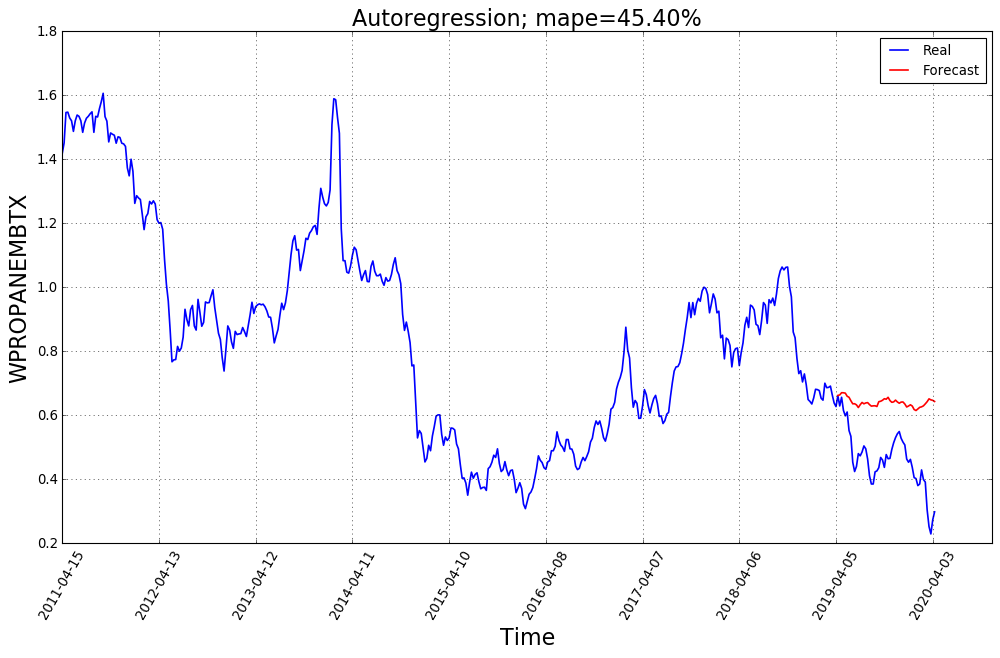

In [17]:
fwd=53
dat=pd.DataFrame({'time':data[data.columns[0]].values, 'data':y})
d=ChooChooExplore(dat, fwd, fwd)
x2=np.arange(len(dat)-fwd,len(dat))
xt=[data.DATE.values[i] for i in range(0, len(data), 52 )]
plt.figure(1, figsize=(15, 8), facecolor='w')
plt.title('Autoregression; mape=%.2f%%'%d[2], size=20)
plt.xlabel('Time', size=20)
plt.ylabel(name, size=20)
#plt.xticks(range(len(dat)),mont, rotation=90, size=12)
plt.yticks(size=12)
plt.grid()
plt.plot(y,color='blue', lw=1.5)
plt.plot(x2, d[5][-fwd:],color='red', lw=1.5)
plt.xticks(np.arange(0, len(data), 52 ), xt, rotation=60)
plt.legend(['Real','Forecast'], loc='best', fontsize=12)
plt.show(block=False)

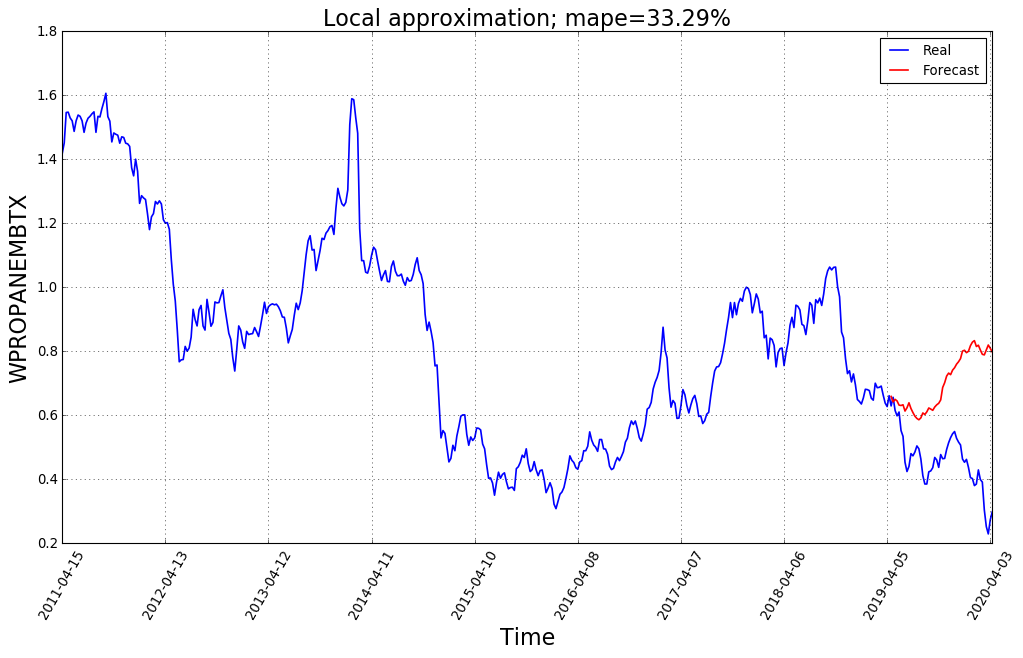

In [18]:
dat=pd.DataFrame({'time':data[data.columns[0]].values, 'data':y})
fwd=52
d=LAprExplore(dat,fwd,fwd)
x1=np.arange(len(dat)-len(d[5]),len(dat)-fwd)
x2=np.arange(len(dat)-fwd,len(dat))
plt.figure(1, figsize=(15, 8), facecolor='w')
plt.title('Local approximation; mape=%.2f%%'%d[2], size=20)
plt.xlabel('Time', size=20)
plt.ylabel(name, size=20)
plt.yticks(size=12)
plt.xticks(np.arange(0, len(data), 52 ), xt, rotation=60)
plt.grid()
plt.plot(y,color='blue', lw=1.5)
plt.plot(x2, d[5][-fwd:],color='red', lw=1.5)
plt.legend(['Real','Forecast'], loc='best', fontsize=12)
plt.show(block=False)

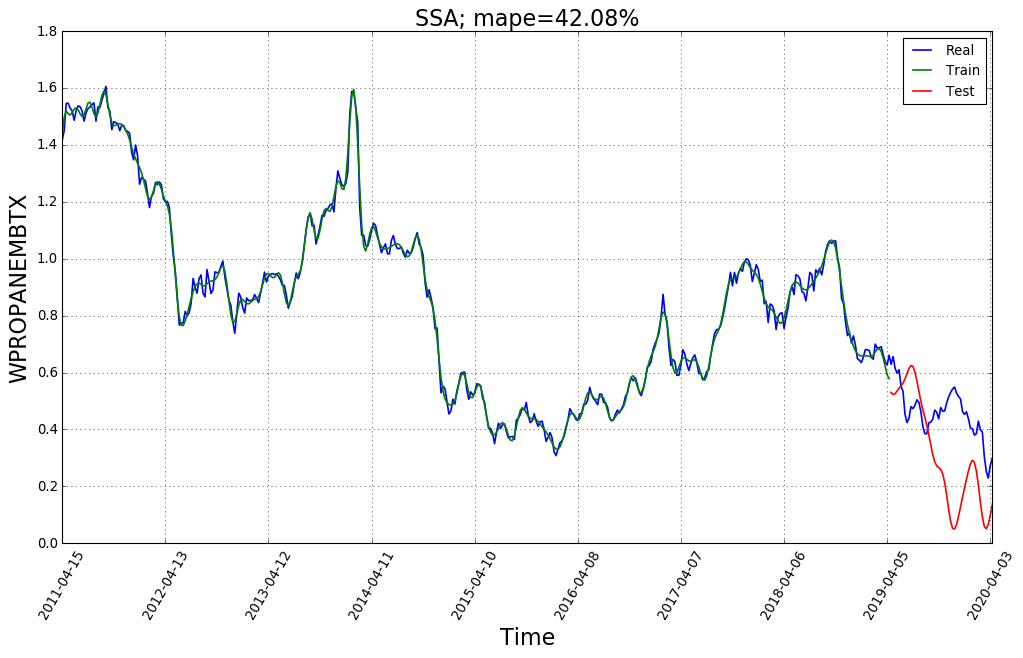

In [19]:
dat=pd.DataFrame({'time':data[data.columns[0]].values, 'data':y})
fwd=52
d=MSSAExplore(dat,fwd,fwd)
x1=np.arange(len(dat)-len(d[5]),len(dat)-fwd)
x2=np.arange(len(dat)-fwd,len(dat))
plt.figure(1, figsize=(15, 8), facecolor='w')
plt.title('SSA; mape=%.2f%%'%d[2], size=20)
plt.xlabel('Time', size=20)
plt.ylabel(name, size=20)
plt.yticks(size=12)
plt.xticks(np.arange(0, len(data), 52 ), xt, rotation=60)
plt.grid()
plt.plot(y,color='blue', lw=1.5)
plt.plot(x1, d[5][:-fwd],color='green', lw=1.5)
plt.plot(x2, d[5][-fwd:],color='red', lw=1.5)
plt.legend(['Real','Train','Test'], loc='best', fontsize=12)
plt.show(block=False)